## Trends in forest loss

Notebook to test the approach of evaluating long-term (multi-year) loss for building a traffic-light system to evaluate progress towards the [Aichi biodiveristy targets](https://www.cbd.int/sp/targets/).

In [84]:
import requests
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np

In [250]:
admin0 = 'BRA'
url = ("https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?"
       "sql=SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area,"
       f"SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'gadm28' AND iso = '{admin0}'"
       "AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)")

In [252]:
r = requests.get(url)
print(f'Returned {r.status_code} status')
d = r.json()

Returned 200 status


In [253]:
years = range(2000, 2016)
loss = []
for row in d.get('data'):
    loss.append(float(f"{row.get('area'):3.2f}"))

In [254]:
df = pd.DataFrame(loss, index=years, columns=['loss'])
df.head()

,loss
2000,2746361.49
2001,3507049.43
2002,3248526.73
2003,3848770.80
2004,3486562.71


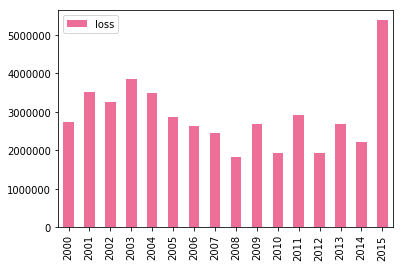

In [255]:
df.plot.bar(color='#ED6F97')

Now we have the data, let's look at trend fitting approaches

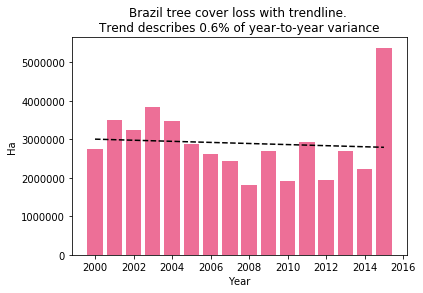

In [190]:
#Naieve example, fitting a trend straight to the data

slope, intercept, r_value, p_value, std_err = stats.linregress(df.index, df.loss)

#print(slope, intercept, r_value, p_value, std_err)
fit_line = []
for yr in df.index:
    fit_line.append(yr * slope + intercept)
    plt.bar(df.index, df.loss, color='#ED6F97')
plt.plot(df.index, fit_line, 'k--')
plt.title(f"Brazil tree cover loss with trendline. \n"
          f"Trend describes {(r_value * r_value) * 100:3.1f}% of year-to-year variance")
plt.xlabel("Year")
plt.ylabel("Ha")
plt.show()

### example using a smooth before a trend
This has the effect of reducing the impact of noise (i.e. year-to-year variability not connected to long-term changes) on the data.

In [192]:
window = 5  # number of years to include in the rolling smooth
smooth = df.rolling(window = window, center = False).mean()

In [193]:
x = np.array(df.index)
y = np.array(smooth.values).flatten()

In [194]:
start = window -1
slope, intercept, r_value, p_value, std_err = stats.linregress(x[start:], y[start:])
print(slope, intercept, r_value, p_value, std_err)

-82844.57941258748 169217488.8432612 -0.679169783740181 0.015140771405747325 28312.008424988177


In [195]:
fit_line = []
for x_element in x[start:]:
    fit_line.append(x_element * slope + intercept)

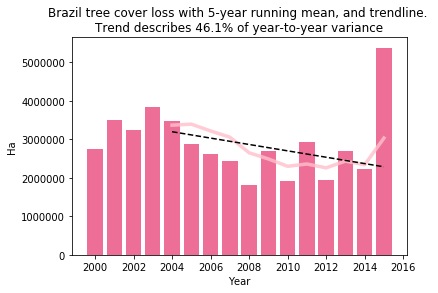

In [196]:
plt.bar(df.index, df.loss, color='#ED6F97')
plt.plot(df.index, smooth, color='pink', alpha=0.8, lw=3.5)
plt.plot(x[start:], fit_line, 'k--')
plt.title(f"Brazil tree cover loss with {window}-year running mean, and trendline. \n"
          f"Trend describes {(r_value * r_value) * 100:3.1f}% of year-to-year variance")
plt.xlabel("Year")
plt.ylabel("Ha")
plt.show()

In [197]:
print(f"Mid-term underlying changes: {slope:6,.0f} ha/yr, standard error: {std_err:6,.0f} ha")

Mid-term underlying changes: -82,845 ha/yr, standard error: 28,312 ha


## View across countries

Now, run a test for a few countries, to extract the mid-term loss trends. Note the Aichi targets are from 2011 to 2020, so we will need to restrict the dates and reduce the running mean smooth a bit to accomodate the shorter window size.

In [313]:
def make_loss_df(d):
    loss = []
    years = []
    for row in d.get('data'):
        y_tmp = row.get('year')
        if y_tmp > 2010:
            loss.append(float(f"{row.get('area'):3.2f}"))
            years.append(y_tmp)
    df = pd.DataFrame(loss, index=years, columns=['loss'])
    return df

In [314]:
def find_trend(df, place=None, window=5):
    """ 
    df should be a dataframe containing loss, with integer years as the index
    window is the number of years to include in the rolling smooth
    """
    smooth = df.rolling(window = window, center = False).mean()

    x = np.array(df.index)
    y = np.array(smooth.values).flatten()

    start = window -1
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[start:], y[start:])
    #print(slope, intercept, r_value, p_value, std_err)
    fit_line = []
    for x_element in x[start:]:
        fit_line.append(x_element * slope + intercept)

    plt.bar(df.index, df.loss, color='#ED6F97')
    plt.plot(df.index, smooth, color='pink', alpha=0.8, lw=3.5)
    plt.plot(x[start:], fit_line, 'k--')
    plt.title(f"{place} tree cover loss with {window}-year running mean, and trendline. \n"
              f"Trend describes {(r_value * r_value) * 100:3.1f}% of year-to-year variance")
    plt.xlabel("Year")
    plt.ylabel("Ha")
    plt.show()
    return slope

grabbing data for BRA


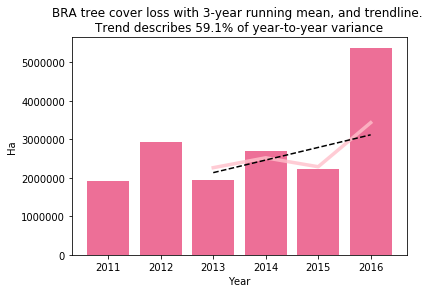

{'slope': 327529.41066666634, 'forest_extent': 403563390.04704916, 'relative_loss_trend': 0.08115934664650368}


grabbing data for COL


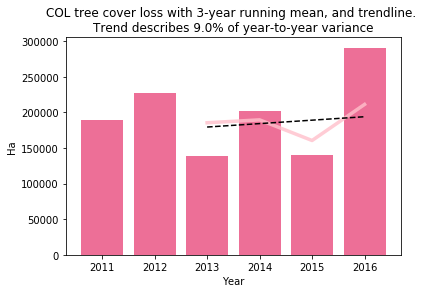

{'slope': 4824.845333333331, 'forest_extent': 66195829.75714874, 'relative_loss_trend': 0.0072887451536360216}


grabbing data for IDN


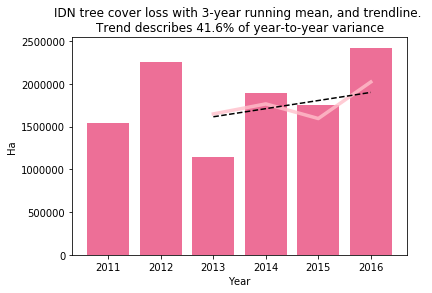

{'slope': 95115.0303333333, 'forest_extent': 128009858.42115581, 'relative_loss_trend': 0.0743028947195632}


grabbing data for RUS


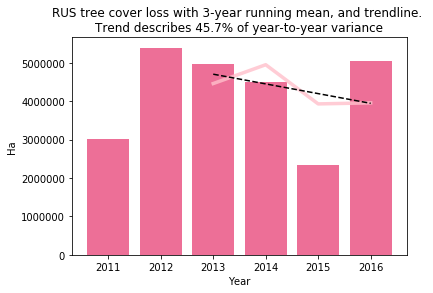

{'slope': -252844.20499999975, 'forest_extent': 610616312.4761534, 'relative_loss_trend': -0.04140803313535358}


grabbing data for ESP


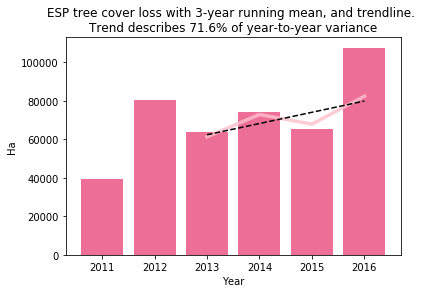

{'slope': 5839.808000000002, 'forest_extent': 8453388.563768566, 'relative_loss_trend': 0.06908245085325386}




In [318]:
# Need to get forest extent too, this is necessary to normalize the slope by (rate of loss)

places = ['BRA', 'COL', 'IDN', 'RUS', 'ESP']
d = {}
for place in places:
    print(f'grabbing data for {place}')

    loss_query = ("https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?"
           "sql=SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area,"
           f"SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'gadm28' AND iso = '{place}'"
           "AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)")

    extent_query = ("https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?"
                    "sql=SELECT SUM(area_extent) as value, SUM(area_gadm28) as total_area FROM data "
                    f"WHERE iso = '{place}' AND thresh = 30 AND polyname = 'gadm28'")

    
    r_extent = requests.get(extent_query)
    forest_extent = r_extent.json().get('data')[0].get('value')
    
    r_loss = requests.get(loss_query)
    if (r_loss.status_code != 200) or (r_extent.status_code != 200):
        print(f'Returned {r_loss.status_code} status for loss query, and {r_extent.status_code} for extent query')
        break
    
    df = make_loss_df(r_loss.json())
    slope = find_trend(df, place=place, window=3)
    place_stats =  {'slope': slope, 'forest_extent': forest_extent, 'relative_loss_trend': (slope/forest_extent)*100}
    print(place_stats)
    d[place] = place_stats
    print('\n')

I propose that we use a traffic-light system to indicate a countries mid-term trend:

If their trend is flat, i.e. they are loosing no more or no less than 0.01% of their original (2000) forest extent a year, they should recieve an amber light. Meaning no clear change over the mid-term. 🔶

If their trend is negative,, i.e. the mid-term regression shows each year they loose less than -0.01% of their 2000 forest extent, they should recieve a green light, meaning there is relative progress towards reducing the amount of deforestation. ✅

If their trend is positive, i.e. the mid-term regression shows that each year they loose more than 0.01% of their 2000 forest extent,  they should recieve a red light. Meaning the deforestation in their country is getting worse over recent years. 🔴